# Image Segmentation of Handwritten Digits

<img src='./output.png' alt='m2nist digits'>

In this project, I build a model that predicts the segmentation masks (pixel-wise label map) of handwritten digits. This model is trained on the [M2NIST dataset](https://www.kaggle.com/farhanhubble/multimnistm2nist), a multi digit MNIST.

Here I build a Convolutional Neural Network (CNN) from scratch for the downsampling path and use a Fully Convolutional Network, FCN-8, to upsample and produce the pixel-wise label map. The model is evaluated using the intersection over union (IOU) and Dice Score.

## Imports

In [1]:
import os
import zipfile

import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

## Download the dataset
[M2NIST](https://www.kaggle.com/farhanhubble/multimnistm2nist) is a **multi digit** [MNIST](http://yann.lecun.com/exdb/mnist/).
Each image has up to 3 digits from MNIST digits and the corresponding labels file has the segmentation masks.

The dataset is available on [Kaggle](https://www.kaggle.com) and it can found [here](https://www.kaggle.com/farhanhubble/multimnistm2nist)


In [3]:
# download zipped dataset
!wget --no-check-certificate \
    https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/m2nist.zip \
    -O ./m2nist.zip

# find and extract to a local folder ('/tmp/training')
local_zip = './m2nist.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./training')
zip_ref.close()

--2025-08-15 16:14:02--  https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/m2nist.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.181.251, 142.250.186.155, 172.217.23.123, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.181.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17378168 (17M) [application/zip]
Saving to: ‘./m2nist.zip’

./m2nist.zip        100%[===================>]  16.57M  6.47MB/s    in 2.6s    

2025-08-15 16:14:05 (6.47 MB/s) - ‘./m2nist.zip’ saved [17378168/17378168]



### Load and Preprocess the Dataset
This dataset can be easily preprocessed since it is available as **Numpy Array Files (.npy)**

1. **combined.npy** has the image files containing the multiple MNIST digits. Each image is of size **64 x 84** (height x width, in pixels).

2. **segmented.npy** has the corresponding segmentation masks. Each segmentation mask is also of size **64 x 84**.

This dataset has **5000** samples and I can make appropriate training, validation, and test splits.

With that, let's define a few utility functions for loading and preprocessing the dataset.

In [4]:
BATCH_SIZE = 32

def read_image_and_annotation(image, annotation):
  '''
  Casts the image and annotation to their expected data type and
  normalizes the input image so that each pixel is in the range [-1, 1]

  Args:
    image (numpy array) -- input image
    annotation (numpy array) -- ground truth label map

  Returns:
    preprocessed image-annotation pair
  '''

  image = tf.cast(image, dtype=tf.float32)
  image = tf.reshape(image, (image.shape[0], image.shape[1], 1,))
  annotation = tf.cast(annotation, dtype=tf.int32)
  image = image / 127.5
  image -= 1

  return image, annotation


def get_training_dataset(images, annos):
  '''
  Prepares shuffled batches of the training set.

  Args:
    images (list of strings) -- paths to each image file in the train set
    annos (list of strings) -- paths to each label map in the train set

  Returns:
    tf Dataset containing the preprocessed train set
  '''
  training_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  training_dataset = training_dataset.map(read_image_and_annotation)

  training_dataset = training_dataset.shuffle(512, reshuffle_each_iteration=True)
  training_dataset = training_dataset.batch(BATCH_SIZE)
  training_dataset = training_dataset.repeat()
  training_dataset = training_dataset.prefetch(-1)

  return training_dataset


def get_validation_dataset(images, annos):
  '''
  Prepares batches of the validation set.

  Args:
    images (list of strings) -- paths to each image file in the val set
    annos (list of strings) -- paths to each label map in the val set

  Returns:
    tf Dataset containing the preprocessed validation set
  '''
  validation_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  validation_dataset = validation_dataset.map(read_image_and_annotation)
  validation_dataset = validation_dataset.batch(BATCH_SIZE)
  validation_dataset = validation_dataset.repeat()

  return validation_dataset


def get_test_dataset(images, annos):
  '''
  Prepares batches of the test set.

  Args:
    images (list of strings) -- paths to each image file in the test set
    annos (list of strings) -- paths to each label map in the test set

  Returns:
    tf Dataset containing the preprocessed validation set
  '''
  test_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  test_dataset = test_dataset.map(read_image_and_annotation)
  test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

  return test_dataset


def load_images_and_segments():
  '''
  Loads the images and segments as numpy arrays from npy files
  and makes splits for training, validation and test datasets.

  Returns:
    3 tuples containing the train, val, and test splits
  '''

  #Loads images and segmentation masks.
  images = np.load('./training/combined.npy')
  segments = np.load('./training/segmented.npy')

  #Makes training, validation, test splits from loaded images and segmentation masks.
  train_images, val_images, train_annos, val_annos = train_test_split(images, segments, test_size=0.2, shuffle=True)
  val_images, test_images, val_annos, test_annos = train_test_split(val_images, val_annos, test_size=0.2, shuffle=True)

  return (train_images, train_annos), (val_images, val_annos), (test_images, test_annos)

I can now load the preprocessed dataset and define the training, validation, and test sets.

In [5]:
# Load Dataset
train_slices, val_slices, test_slices = load_images_and_segments()

# Create training, validation, test datasets.
training_dataset = get_training_dataset(train_slices[0], train_slices[1])
validation_dataset = get_validation_dataset(val_slices[0], val_slices[1])
test_dataset = get_test_dataset(test_slices[0], test_slices[1])

2025-08-15 16:17:51.894250: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-08-15 16:17:51.894488: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-08-15 16:17:51.894492: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
I0000 00:00:1755267471.894979 1383375 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1755267471.895034 1383375 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Let's Take a Look at the Dataset
I want to visually inspect the dataset before and after training. Like above, I've included utility functions to help show a few images as well as their annotations (i.e. labels).

In [6]:
# Visualization Utilities

# there are 11 classes in the dataset: one class for each digit (0 to 9) plus the background class
n_classes = 11

# assign a random color for each class
colors = [tuple(np.random.randint(256, size=3) / 255.0) for i in range(n_classes)]

def fuse_with_pil(images):
  '''
  Creates a blank image and pastes input images

  Args:
    images (list of numpy arrays) - numpy array representations of the images to paste

  Returns:
    PIL Image object containing the images
  '''

  widths = (image.shape[1] for image in images)
  heights = (image.shape[0] for image in images)
  total_width = sum(widths)
  max_height = max(heights)

  new_im = PIL.Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    pil_image = PIL.Image.fromarray(np.uint8(im))
    new_im.paste(pil_image, (x_offset,0))
    x_offset += im.shape[1]

  return new_im


def give_color_to_annotation(annotation):
  '''
  Converts a 2-D annotation to a numpy array with shape (height, width, 3) where
  the third axis represents the color channel. The label values are multiplied by
  255 and placed in this axis to give color to the annotation

  Args:
    annotation (numpy array) - label map array

  Returns:
    the annotation array with an additional color channel/axis
  '''
  seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')

  for c in range(n_classes):
    segc = (annotation == c)
    seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
    seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
    seg_img[:,:,2] += segc*( colors[c][2] * 255.0)

  return seg_img


def show_annotation_and_prediction(image, annotation, prediction, iou_list, dice_score_list):
  '''
  Displays the images with the ground truth and predicted label maps. Also overlays the metrics.

  Args:
    image (numpy array) -- the input image
    annotation (numpy array) -- the ground truth label map
    prediction (numpy array) -- the predicted label map
    iou_list (list of floats) -- the IOU values for each class
    dice_score_list (list of floats) -- the Dice Score for each class
  '''

  new_ann = np.argmax(annotation, axis=2)
  true_img = give_color_to_annotation(new_ann)
  pred_img = give_color_to_annotation(prediction)

  image = image + 1
  image = image * 127.5
  image = np.reshape(image, (image.shape[0], image.shape[1],))
  image = np.uint8(image)
  images = [image, np.uint8(pred_img), np.uint8(true_img)]

  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0 and idx < 10]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place

  display_string_list = ["{}: IOU: {} Dice Score: {}".format(idx, iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n".join(display_string_list)

  plt.figure(figsize=(15, 4))

  for idx, im in enumerate(images):
    plt.subplot(1, 3, idx+1)
    if idx == 1:
      plt.xlabel(display_string)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(im)


def show_annotation_and_image(image, annotation):
  '''
  Displays the image and its annotation side by side

  Args:
    image (numpy array) -- the input image
    annotation (numpy array) -- the label map
  '''
  new_ann = np.argmax(annotation, axis=2)
  seg_img = give_color_to_annotation(new_ann)

  image = image + 1
  image = image * 127.5
  image = np.reshape(image, (image.shape[0], image.shape[1],))

  image = np.uint8(image)
  images = [image, seg_img]

  images = [image, seg_img]
  fused_img = fuse_with_pil(images)
  plt.imshow(fused_img)


def list_show_annotation(dataset, num_images):
  '''
  Displays images and its annotations side by side

  Args:
    dataset (tf Dataset) -- batch of images and annotations
    num_images (int) -- number of images to display
  '''
  ds = dataset.unbatch()

  plt.figure(figsize=(20, 15))
  plt.title("Images And Annotations")
  plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)

  for idx, (image, annotation) in enumerate(ds.take(num_images)):
    plt.subplot(5, 5, idx + 1)
    plt.yticks([])
    plt.xticks([])
    show_annotation_and_image(image.numpy(), annotation.numpy())


I can view a subset of the images from the dataset with the `list_show_annotation()` function defined above. Let's run the cells below to see the image on the left and its pixel-wise ground truth label map on the right.

2025-08-15 16:23:21.052737: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


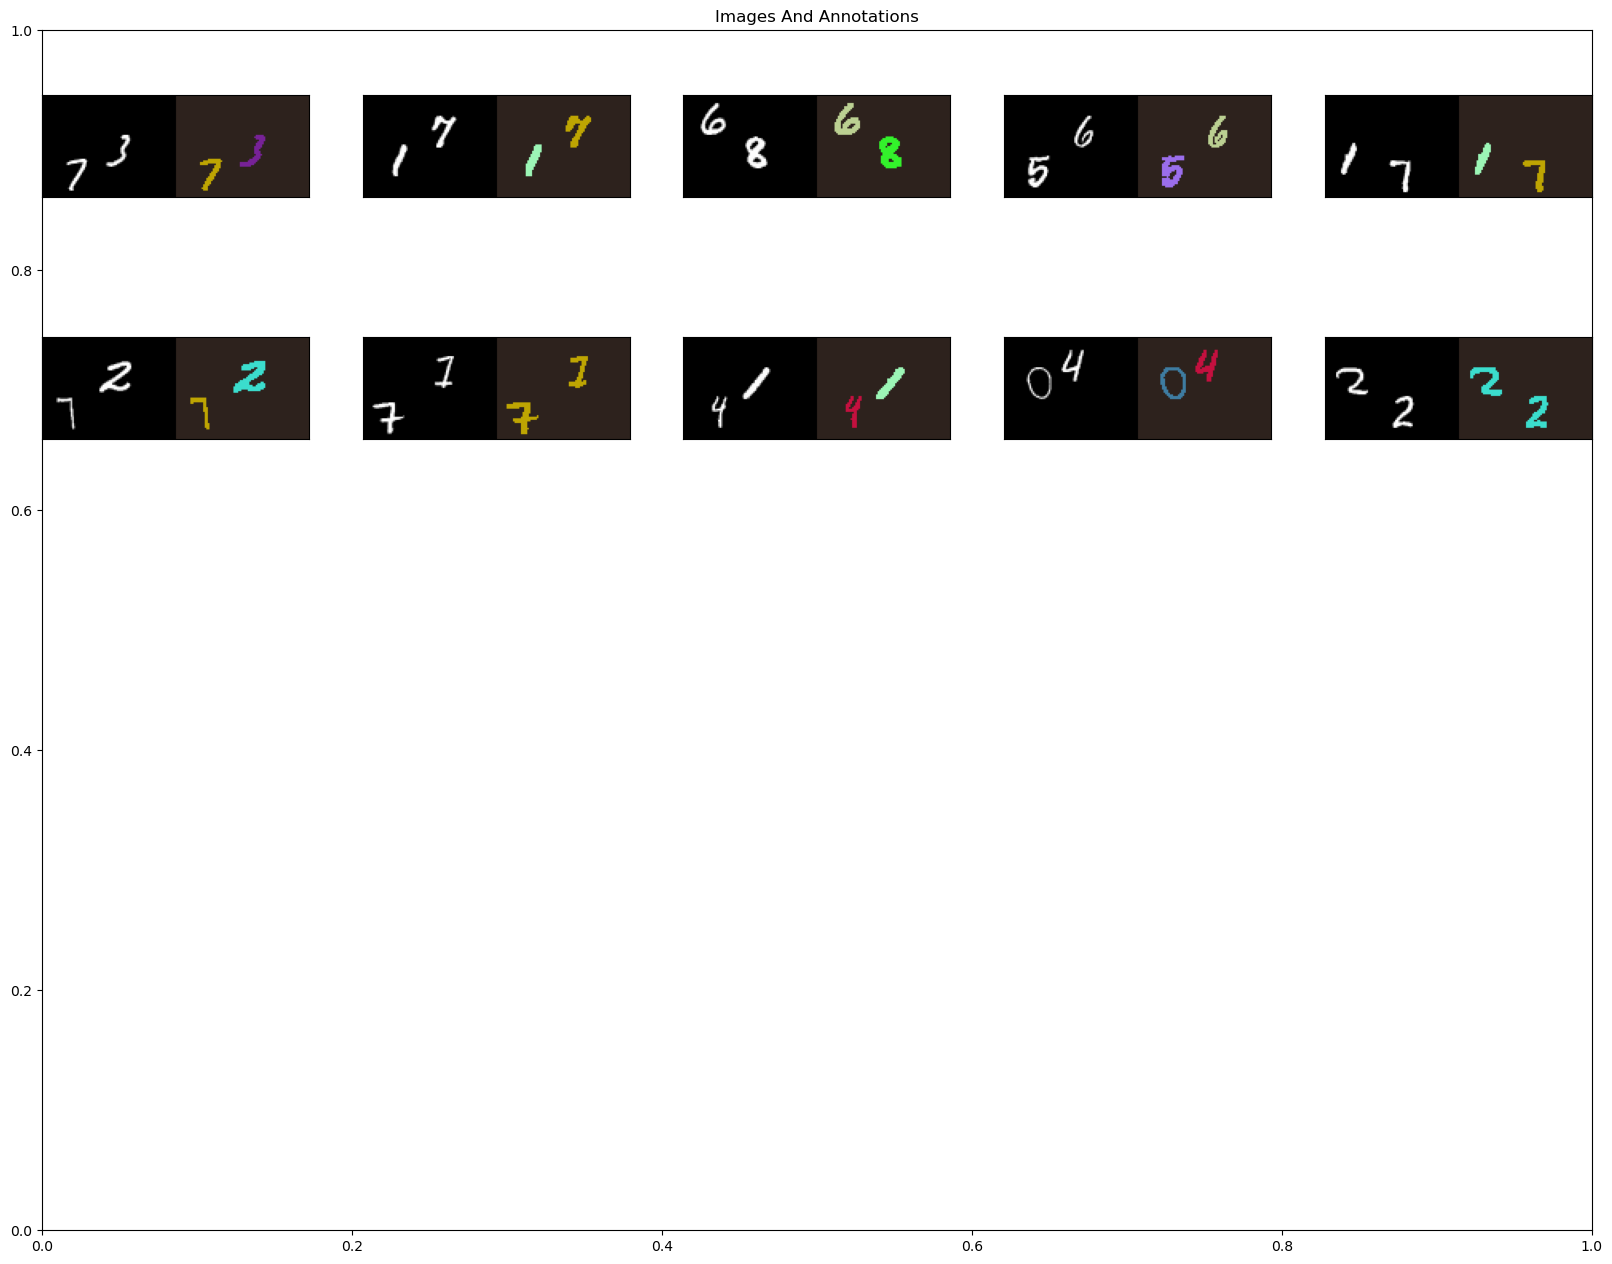

In [7]:
# get 10 images from the training set
list_show_annotation(training_dataset, 10)

2025-08-15 16:23:45.653004: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


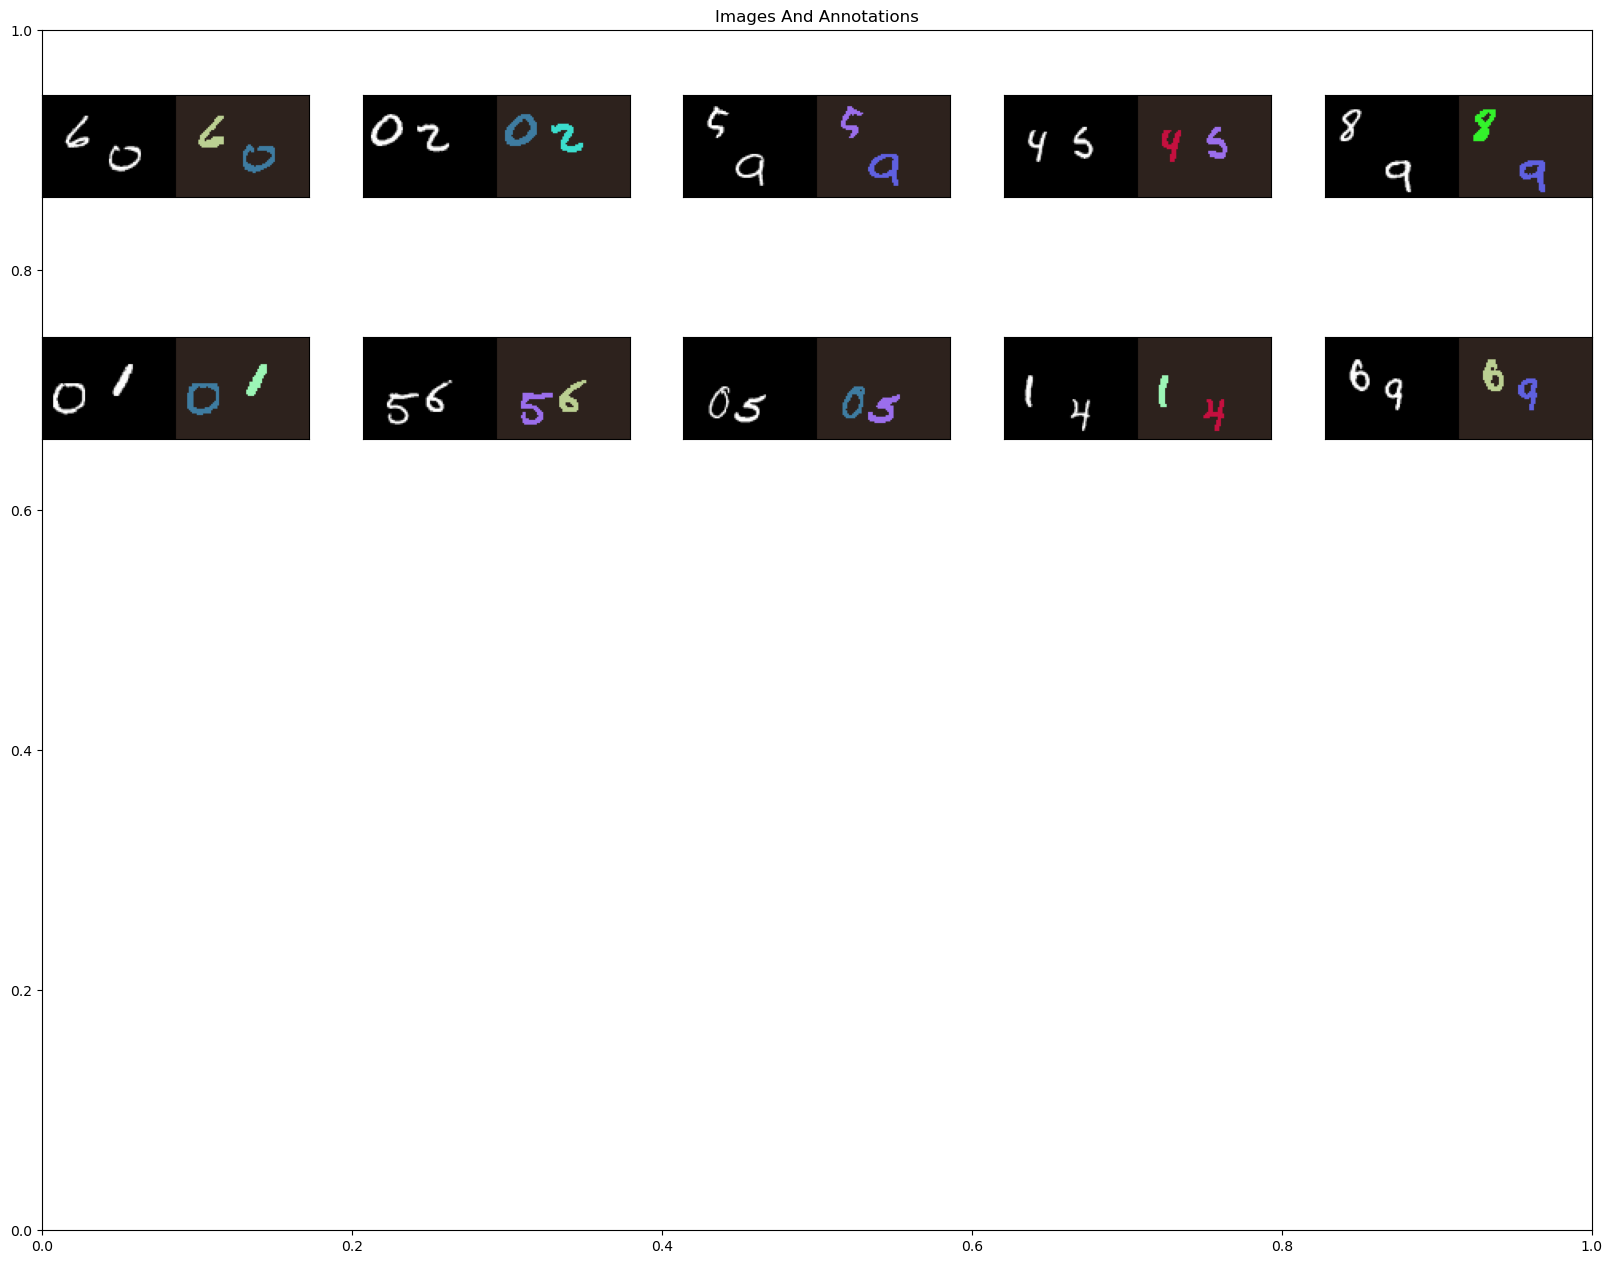

In [8]:
# get 10 images from the validation set
list_show_annotation(validation_dataset, 10)

can be seen from the images above the colors assigned to each class (i.e 0 to 9 plus the background). to change colors I can rerun the cell where `colors` is defined to get another set of random colors

## Define the Model
the image segmentation model has two paths:

1. **Downsampling Path** - This part of the network extracts the features in the image. This is done through a series of convolution and pooling layers. The final output is a reduced image (because of the pooling layers) with the extracted features. I build a custom CNN from scratch for this path.

2. **Upsampling Path** - This takes the output of the downsampling path and generates the predictions while also converting the image back to its original size. I use an FCN-8 decoder for this path.

### Define the Basic Convolution Block

<a name='exercise-1'></a>
function below build the basic convolution block for my CNN. This have two [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/) layers each followed by a [LeakyReLU](https://keras.io/api/layers/activation_layers/leaky_relu/), then [max pooled](https://keras.io/api/layers/pooling_layers/max_pooling2d/) and [batch-normalized](https://keras.io/api/layers/normalization_layers/batch_normalization/). the functional syntax to stack these layers:

$$Input -> Conv2D -> LeakyReLU -> Conv2D -> LeakyReLU -> MaxPooling2D -> BatchNormalization$$

When defining the Conv2D layers, note that our data inputs will have the 'channels' dimension last. check the `data_format` argument in the [docs](https://keras.io/api/layers/convolution_layers/convolution2d/) regarding this.

In [11]:
# parameter describing where the channel dimension is found in my dataset
IMAGE_ORDERING = 'channels_last'

def conv_block(input, filters, kernel_size, pooling_size, pool_strides):
  '''
  Args:
    input (tensor) -- batch of images or features
    filters (int) -- number of filters of the Conv2D layers
    kernel_size (int) -- kernel_size setting of the Conv2D layers
    pooling_size (int) -- pooling size of the MaxPooling2D layers
    pool_strides (int) -- strides setting of the MaxPooling2D layers

  Returns:
    (tensor) max pooled and batch-normalized features of the input
  '''

  x = Conv2D(filters, (kernel_size, kernel_size), padding='same',
             data_format=IMAGE_ORDERING)(input)
  x = LeakyReLU()(x)
  x = Conv2D(filters, (kernel_size, kernel_size), padding='same',
             data_format=IMAGE_ORDERING)(x)
  x = LeakyReLU()(x)
  x = MaxPooling2D(pool_size=(pooling_size, pooling_size),
                   strides=(pool_strides, pool_strides),
                   data_format=IMAGE_ORDERING)(x)
  x = BatchNormalization(axis=-1 if IMAGE_ORDERING == 'channels_last' else 1)(x)


  return x


In [12]:
# TEST CODE:

test_input = tf.keras.layers.Input(shape=(64,84, 1))
test_output = conv_block(test_input, 32, 3, 2, 2)
test_model = tf.keras.Model(inputs=test_input, outputs=test_output)

print(test_model.summary())

# free up test resources
del test_input, test_output, test_model

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 84, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 84, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64, 84, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 84, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 84, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 42, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 42, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,696 (37.88 KB)

 Trainable params: 9,632 (37.62 KB)

 Non-trainable params: 64 (256.00 B)

None


### Define the Downsampling Path

Now that I've defined the building block of the encoder, I now build the downsampling path. It chains together five convolution building blocks to create a feature extraction CNN minus the fully connected layers.

*Notes*:
1. To optimize processing or to make the output dimensions of each layer easier to work with, it is sometimes advisable to apply some zero-padding to the input image. With the boilerplate code provided below, I have padded the input width to 96 pixels using the [ZeroPadding2D layer](https://keras.io/api/layers/reshaping_layers/zero_padding2d/). 

2. I'm keeping the pool size and stride parameters constant at 2.

In [18]:
from tensorflow.keras.layers import ZeroPadding2D

def FCN8(input_height=64, input_width=84):
    '''
    Defines the downsampling path of the image segmentation model.

    Args:
      input_height (int) -- height of the images
      width (int) -- width of the images

    Returns:
    (tuple of tensors, tensor)
      tuple of tensors -- features extracted at blocks 3 to 5
      tensor -- copy of the input
    '''
    img_input = tf.keras.layers.Input(shape=(input_height, input_width, 1))

    # pad the input image width to 96 pixels (add 6 left, 6 right)
    x = ZeroPadding2D(padding=((0, 0), (6, 6)), data_format=IMAGE_ORDERING)(img_input)

    # Block 1: 32 filters
    x = conv_block(x, filters=32,  kernel_size=3, pooling_size=2, pool_strides=2)

    # Block 2: 64 filters
    x = conv_block(x, filters=64,  kernel_size=3, pooling_size=2, pool_strides=2)

    # Block 3: 128 filters (save f3)
    x  = conv_block(x, filters=128, kernel_size=3, pooling_size=2, pool_strides=2)
    f3 = x

    # Block 4: 256 filters (save f4)
    x  = conv_block(x, filters=256, kernel_size=3, pooling_size=2, pool_strides=2)
    f4 = x

    # Block 5: 256 filters (save f5)
    x  = conv_block(x, filters=256, kernel_size=3, pooling_size=2, pool_strides=2)
    f5 = x

    return (f3, f4, f5), img_input



In [19]:
# TEST CODE:

test_convs, test_img_input = FCN8()
test_model = tf.keras.Model(inputs=test_img_input, outputs=[test_convs, test_img_input])

print(test_model.summary())

del test_convs, test_img_input, test_model

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 64, 84, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 64, 96, 1)      │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 96, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 64, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 64, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 32, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 32, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 16, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 16, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 16, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 12, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 12, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 8, 12, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 8, 12, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 8, 12, 256)     │       590,08

 Total params: 2,354,784 (8.98 MB)

 Trainable params: 2,353,312 (8.98 MB)

 Non-trainable params: 1,472 (5.75 KB)

None


### Define the FCN-8 decoder

Now I can define the upsampling path taking the outputs of convolutions at each stage as arguments.
* Note: remember to set the `data_format` parameter for the Conv2D layers.

Here is also the diagram on how it should work:

<img src='./FCN-8.png' alt='fcn-8'>

In [ ]:

def fcn8_decoder(convs, n_classes):
  # features from the encoder stage
  f3, f4, f5 = convs

  # number of filters
  n = 512

  # add convolutional layers on top of the CNN extractor.
  o = tf.keras.layers.Conv2D(n , (7 , 7) , activation='relu' , padding='same',
                             name="conv6", data_format=IMAGE_ORDERING)(f5)
  o = tf.keras.layers.Dropout(0.5)(o)

  o = tf.keras.layers.Conv2D(n , (1 , 1) , activation='relu' , padding='same',
                             name="conv7", data_format=IMAGE_ORDERING)(o)
  o = tf.keras.layers.Dropout(0.5)(o)

  o = tf.keras.layers.Conv2D(n_classes,  (1, 1), activation='relu' , padding='same',
                             data_format=IMAGE_ORDERING)(o)


  # Upsample `o` (1/32 -> 1/16) and crop any extra pixels introduced (no-op crop here)
  o = tf.keras.layers.Conv2DTranspose(n_classes, (2, 2), strides=(2, 2),
                                      padding='same', data_format=IMAGE_ORDERING)(o)
  o = tf.keras.layers.Cropping2D(((0, 0), (0, 0)), data_format=IMAGE_ORDERING)(o)

  # pool4 1x1 prediction to match channels, then fuse
  o2 = f4
  o2 = tf.keras.layers.Conv2D(n_classes, (1, 1), activation='relu', padding='same',
                              data_format=IMAGE_ORDERING)(o2)
  o = tf.keras.layers.Add()([o, o2])

  # Upsample (1/16 -> 1/8) and crop (no-op crop)
  o = tf.keras.layers.Conv2DTranspose(n_classes, (2, 2), strides=(2, 2),
                                      padding='same', data_format=IMAGE_ORDERING)(o)
  o = tf.keras.layers.Cropping2D(((0, 0), (0, 0)), data_format=IMAGE_ORDERING)(o)

  # pool3 1x1 prediction to match channels, then fuse
  o2 = f3
  o2 = tf.keras.layers.Conv2D(n_classes, (1, 1), activation='relu', padding='same',
                              data_format=IMAGE_ORDERING)(o2)
  o = tf.keras.layers.Add()([o, o2])

  # Upsample to original padded size (1/8 -> 1/1), then crop width back to 84
  o = tf.keras.layers.Conv2DTranspose(n_classes, (8, 8), strides=(8, 8),
                                      padding='same', data_format=IMAGE_ORDERING)(o)
  o = tf.keras.layers.Cropping2D(((0, 0), (0, 96-84)), data_format=IMAGE_ORDERING)(o)

  # Final activation for binary mask
  o = tf.keras.layers.Activation('sigmoid')(o)

  return o


In [22]:
# TEST CODE

test_convs, test_img_input = FCN8()
test_fcn8_decoder = fcn8_decoder(test_convs, 11)

print(test_fcn8_decoder.shape)

del test_convs, test_img_input, test_fcn8_decoder

(None, 64, 84, 11)


### Define the Complete Model
The downsampling and upsampling paths can now be combined as shown below.

In [23]:
# start the encoder using the default input size 64 x 84
convs, img_input = FCN8()

# pass the convolutions obtained in the encoder to the decoder
dec_op = fcn8_decoder(convs, n_classes)

# define the model specifying the input (batch of images) and output (decoder output)
model = tf.keras.Model(inputs = img_input, outputs = dec_op)

In [24]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 64, 84, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 64, 96, 1) │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 64, 96,    │        320 │ zero_padding2d_3… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_32      │ (None, 64, 96,    │          0 │ conv2d_35[0][0]   │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 64, 96,    │      9,248 │ leaky_re_lu_32[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_33      │ (None, 64, 96,    │          0 │ conv2d_36[0][0]   │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 32, 48,    │          0 │ leaky_re_lu_33[0… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 48,    │        128 │ max_pooling2d_16… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 32, 48,    │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_34      │ (None, 32, 48,    │          0 │ conv2d_37[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 32, 48,    │     36,928 │ leaky_re_lu_34[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_35      │ (None, 32, 48,    │          0 │ conv2d_38[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 16, 24,    │          0 │ leaky_re_lu_35[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 24,    │        256 │ max_pooling2d_17… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 16, 24,    │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_36      │ (None, 16, 24,    │          0 │ conv2d_39[0][0]   │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 16, 24,    │    147,584 │ leaky_re_lu_36[0

 Total params: 9,059,114 (34.56 MB)

 Trainable params: 9,057,642 (34.55 MB)

 Non-trainable params: 1,472 (5.75 KB)

### Compile the Model
Compile the model using an appropriate loss, optimizer, and metric.

In [26]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']  
)

## Model Training
I can now train the model. Set the number of epochs and observe the metrics returned at each iteration.

In [28]:
# OTHER THAN SETTING THE EPOCHS NUMBER, DO NOT CHANGE ANY OTHER CODE

EPOCHS = 70

steps_per_epoch = 4000//BATCH_SIZE
validation_steps = 800//BATCH_SIZE
test_steps = 200//BATCH_SIZE


history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS)

Epoch 1/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.9419 - loss: 0.0480 - val_accuracy: 0.9441 - val_loss: 0.0506
Epoch 2/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.9422 - loss: 0.0422 - val_accuracy: 0.9441 - val_loss: 0.0415
Epoch 3/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.9422 - loss: 0.0397 - val_accuracy: 0.9441 - val_loss: 0.0382
Epoch 4/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.9422 - loss: 0.0381 - val_accuracy: 0.9441 - val_loss: 0.0363
Epoch 5/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - accuracy: 0.9422 - loss: 0.0369 - val_accuracy: 0.9441 - val_loss: 0.0354
Epoch 6/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.9422 - loss: 0.0358 - val_accuracy: 0.9441 - val_loss: 0.0340
Epoch 7/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.9422 - loss: 0.0348 - val_accuracy: 0.9441 - val_loss: 0.0330
Epoch 8/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.9421 - loss: 0.0339 - 

## Model Evaluation
### Make Predictions

Let's get the predictions using our test dataset as input and print the shape.

In [29]:
results = model.predict(test_dataset, steps=test_steps)

print(results.shape)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
(192, 64, 84, 11)


As we can see, the resulting shape is `(192, 64, 84, 11)`. This means that for each of the 192 images that we have in our test set, there are 11 predictions generated (i.e. one for each class: 0 to 1 plus background).

Thus, if I want to see the *probability* of the upper leftmost pixel of the 1st image belonging to class 0, then I can print something like `results[0,0,0,0]`. If I want the probability of the same pixel at class 10, then do `results[0,0,0,10]`.


In [30]:
print(results[0,0,0,0])
print(results[0,0,0,10])

1.7456083e-06
0.99600583


What we're interested in is to get the *index* of the highest probability of each of these 11 slices and combine them in a single image. We can do that by getting the [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) at this axis.

In [31]:
results = np.argmax(results, axis=3)

print(results.shape)

(192, 64, 84)


The new array generated per image now only specifies the indices of the class with the highest probability. Let's see the output class of the upper most left pixel. As I have observed earlier while inspecting the dataset, the upper left corner is usually just part of the background (class 10). The actual digits are written somewhere in the middle parts of the image.

In [32]:
print(results[0,0,0])

# prediction map for image 0
print(results[0,:,:])

10
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]


### Metrics

Let's recall two ways to evaluate your predictions. The *intersection over union (IOU)* and the *dice score*:

$$IOU = \frac{area\_of\_overlap}{area\_of\_union}$$
<br>

$$Dice Score = 2 * \frac{area\_of\_overlap}{combined\_area}$$


A small smoothing factor is introduced in the denominators to prevent possible division by zero.

In [33]:
def class_wise_metrics(y_true, y_pred):
  '''
  Computes the class-wise IOU and Dice Score.

  Args:
    y_true (tensor) - ground truth label maps
    y_pred (tensor) - predicted label maps
  '''
  class_wise_iou = []
  class_wise_dice_score = []

  smoothing_factor = 0.00001

  for i in range(n_classes):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area

    iou = (intersection) / (combined_area - intersection + smoothing_factor)
    class_wise_iou.append(iou)

    dice_score =  2 * ((intersection) / (combined_area + smoothing_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score


### Visualize Predictions

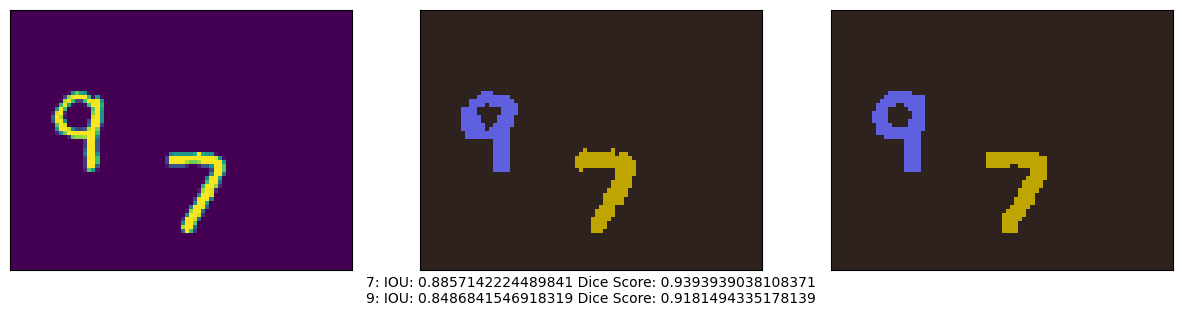

In [46]:
# place a number here between 0 to 191 to pick an image from the test set
integer_slider = 137

ds = test_dataset.unbatch()
ds = ds.batch(200)
images = []

y_true_segments = []
for image, annotation in ds.take(2):
  y_true_segments = annotation
  images = image


iou, dice_score = class_wise_metrics(np.argmax(y_true_segments[integer_slider], axis=2), results[integer_slider])
show_annotation_and_prediction(image[integer_slider], annotation[integer_slider], results[integer_slider], iou, dice_score)


### Compute IOU Score and Dice Score of the model

In [47]:
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(np.argmax(y_true_segments, axis=3), results)

average_iou = 0.0
for idx, (iou, dice_score) in enumerate(zip(cls_wise_iou[:-1], cls_wise_dice_score[:-1])):
  print("Digit {}: IOU: {} Dice Score: {}".format(idx, iou, dice_score))
  average_iou += iou

grade = average_iou * 10

print("\nGrade is " + str(grade))

PASSING_GRADE = 60
if (grade>PASSING_GRADE):
  print("You passed!")
else:
  print("You failed. Please check your model and re-train")

Digit 0: IOU: 0.7869816373148529 Dice Score: 0.8807943191821311
Digit 1: IOU: 0.8045272947948674 Dice Score: 0.8916765039969355
Digit 2: IOU: 0.7249373422228426 Dice Score: 0.8405375945872343
Digit 3: IOU: 0.7002976645773185 Dice Score: 0.8237353719490138
Digit 4: IOU: 0.6950113365551562 Dice Score: 0.8200668887178741
Digit 5: IOU: 0.5522959173609768 Dice Score: 0.711585866050492
Digit 6: IOU: 0.734715575844344 Dice Score: 0.8470732448306212
Digit 7: IOU: 0.7792169549908494 Dice Score: 0.8759099926572551
Digit 8: IOU: 0.6487321535811506 Dice Score: 0.7869466876982574
Digit 9: IOU: 0.7214473674717798 Dice Score: 0.8381869595366606

Grade is 71.48163244714138
You passed!


## Save the Model

In [49]:
model.save("model.keras")